# Order parameters of Swarm Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import trackpy as tp
from matplotlib import rc

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as wd
from IPython.display import display

rc('text', usetex=True)
%matplotlib inline

In [2]:
Trayectories = pd.read_csv("//MAGNETIC/Antonio/RotatingMill/Swarms.dat",sep='\t',index_col = 'frame')

C:\ProgramFiles\Anaconda3\envs\video\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
Center = pd.read_csv("//MAGNETIC/Antonio/RotatingMill/Swarms_Center.dat",sep='\t',index_col = 'frame')

In [4]:
for i in Center.index:
    x0 = Center[Center.index==i].x
    y0 = Center[Center.index==i].y
    if i in Trayectories.index:
        Trayectories.loc[i,'x0'] = Trayectories.loc[i,'x']-x0
        Trayectories.loc[i,'y0'] = Trayectories.loc[i,'y']-y0

(-329.33575771291538,
 149.15958361042894,
 -154.01814522692334,
 202.47493977886651)

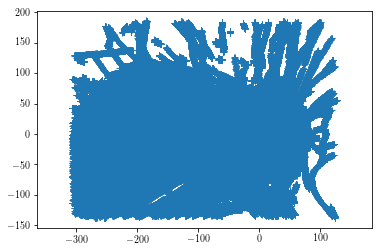

In [5]:
plt.plot(Trayectories.x0,Trayectories.y0,'+')
plt.axis('equal')

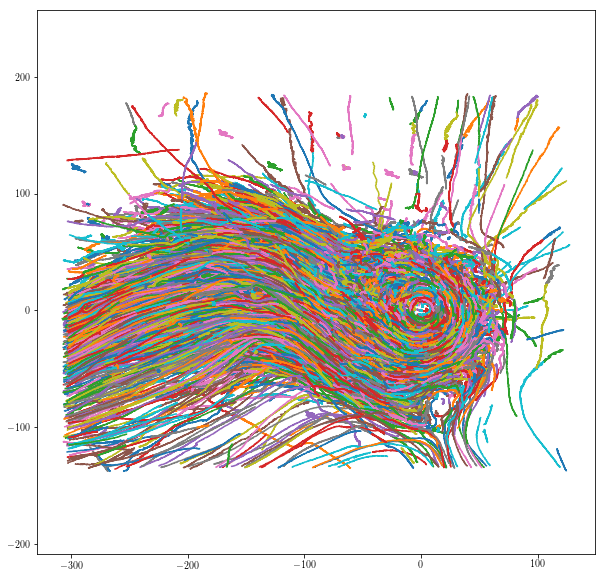

In [6]:
T_Norm = Trayectories
T_Norm.x=Trayectories.x0
T_Norm.y=Trayectories.y0

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.axis('equal')

for p in T_Norm.particle.unique():
    prt_ind = T_Norm.particle==p
    plt.plot(T_Norm[prt_ind].x0,T_Norm[prt_ind].y0)

In [9]:
NumberOfFrames = Trayectories.index.max()

w = wd.IntSlider(
    value=0,
    min=0,
    max=NumberOfFrames,
    step=10,
    continuous_update=False)

@interact(i = w)
def Display(i):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    fr_ind=(Trayectories.index==i)
    ax.plot(Trayectories[fr_ind].x0,Trayectories[fr_ind].y0,'o')
    ax.plot(0,0,'o',color='red')
    ax.axis('equal')
    plt.xlim([-300,100])
    plt.ylim([-150,200])

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=1817, step=10), Output()), _dom_classes=('widget-interact',))

In [ ]:
Trayectories['r'] = np.sqrt(Trayectories.x0**2+Trayectories.y0**2)
Trayectories['phi'] = np.arctan2(Trayectories.y0,Trayectories.x0)

Trayectories['vr']=0
Trayectories['omg']=0
Trayectories['vth']=0

Trayectories['vx']=0
Trayectories['vy']=0

for i in Trayectories.particle.unique():
    location = Trayectories.particle==i
    Trayectories.loc[location,'vr'] = np.append(np.diff(Trayectories[location].r),np.NaN)*10
    Trayectories.loc[location,'omg'] = np.append(np.diff(np.unwrap(Trayectories[location].phi)),np.NaN)*10
    Trayectories.loc[location,'vx'] = np.append(np.diff(Trayectories[location].x),np.NaN)*10
    Trayectories.loc[location,'vy'] = np.append(np.diff(Trayectories[location].y),np.NaN)*10
    
Trayectories['vth'] = Trayectories['r']*Trayectories['omg']

In [ ]:
Order = Trayectories.filter(['frame','t','bining'])

Order['px'] = Trayectories['vx']
Order['py'] = Trayectories['vy']

Order['m'] = Trayectories['vx']*Trayectories['y']-Trayectories['vy']*Trayectories['x']

Order['p_mag'] = np.sqrt(Trayectories['vx']**2 + Trayectories['vy']**2)
Order['m_mag'] = Trayectories['r'] * Order['p_mag']

In [ ]:
Sum = Order.groupby('t').sum();

#Sum['t']=Order.groupby('frame'),
Sum['M']=Sum.m/Sum.m_mag
Sum['P']=np.sqrt((Sum.px/Sum.p_mag)**2 + (Sum.py/Sum.p_mag)**2)

plt.plot(Sum.index,Sum.M);
plt.plot(Sum.index,Sum.P);
plt.xlabel('$t$')
plt.ylabel('$Order$')
plt.legend(['$M$','$P$'])

In [ ]:
Sum_Filter = Sum.rolling(window=100,center=False).mean()

In [ ]:
plt.plot(Sum_Filter.index,Sum_Filter.M);
plt.plot(Sum_Filter.index,Sum_Filter.P);
plt.xlabel('$t$')
plt.ylabel('$Order$')
plt.legend(['$M$','$P$'])